# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
from numpy import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.color

# Root directory of the project
from cell_mrcnn import __file__ as path
ROOT_DIR = path.split('src')[0]

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from cell_mrcnn import utils
from cell_mrcnn import visualize
from cell_mrcnn.visualize import display_images
import cell_mrcnn.model as modellib
from cell_mrcnn.model import log

from cell_mrcnn import cell

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Osteoclast trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CELL_WEIGHTS_PATH = "/home/miska/repos/cell_mrcnn/logs/cell20201122T1428/mask_rcnn_cell_0002.h5"

Using TensorFlow backend.


In [2]:
def cell2rgb(image):    
    zeros = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
    image_rgb = np.stack([image[:,:,0], zeros, image[:,:,1]], axis=2)
    return image_rgb

In [3]:
config = cell.CellInferenceConfig()
Cell_DIR = os.path.join(ROOT_DIR, "data/annotated_datasets/2020_11_22_02_55_03/")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet18
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.98
DETECTION_NMS_THRESHOLD        0.3
DIV_FILTERNB                   2
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    2]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = cell.CellDataset()
dataset.load_cell(Cell_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 5
Classes: ['BG', 'cell']


## Load Model

In [8]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Set path to cz weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/miska/repos/cell_mrcnn/logs/cell20201123T1456/mask_rcnn_cell_0010.h5






Re-starting from epoch 10


## Run Detection

In [10]:
len(dataset.image_ids)

5

Processing 1 images
image                    shape: (2048, 2048, 2)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 2)    min:   -4.50000  max:  253.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  int64
anchors                  shape: (1, 1047552, 4)       min:   -0.17686  max:    1.14560  float32
Processing 1 images
image                    shape: (2048, 2048, 2)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 2)    min:   -4.50000  max:  253.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  int64
anchors                  shape: (1, 1047552, 4)       min:   -0.17686  max:    1.14560  float32
Processing 1 images
image                    shape: (2048, 2048, 2)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 2)    min:   -4.50000  max:  253.50000

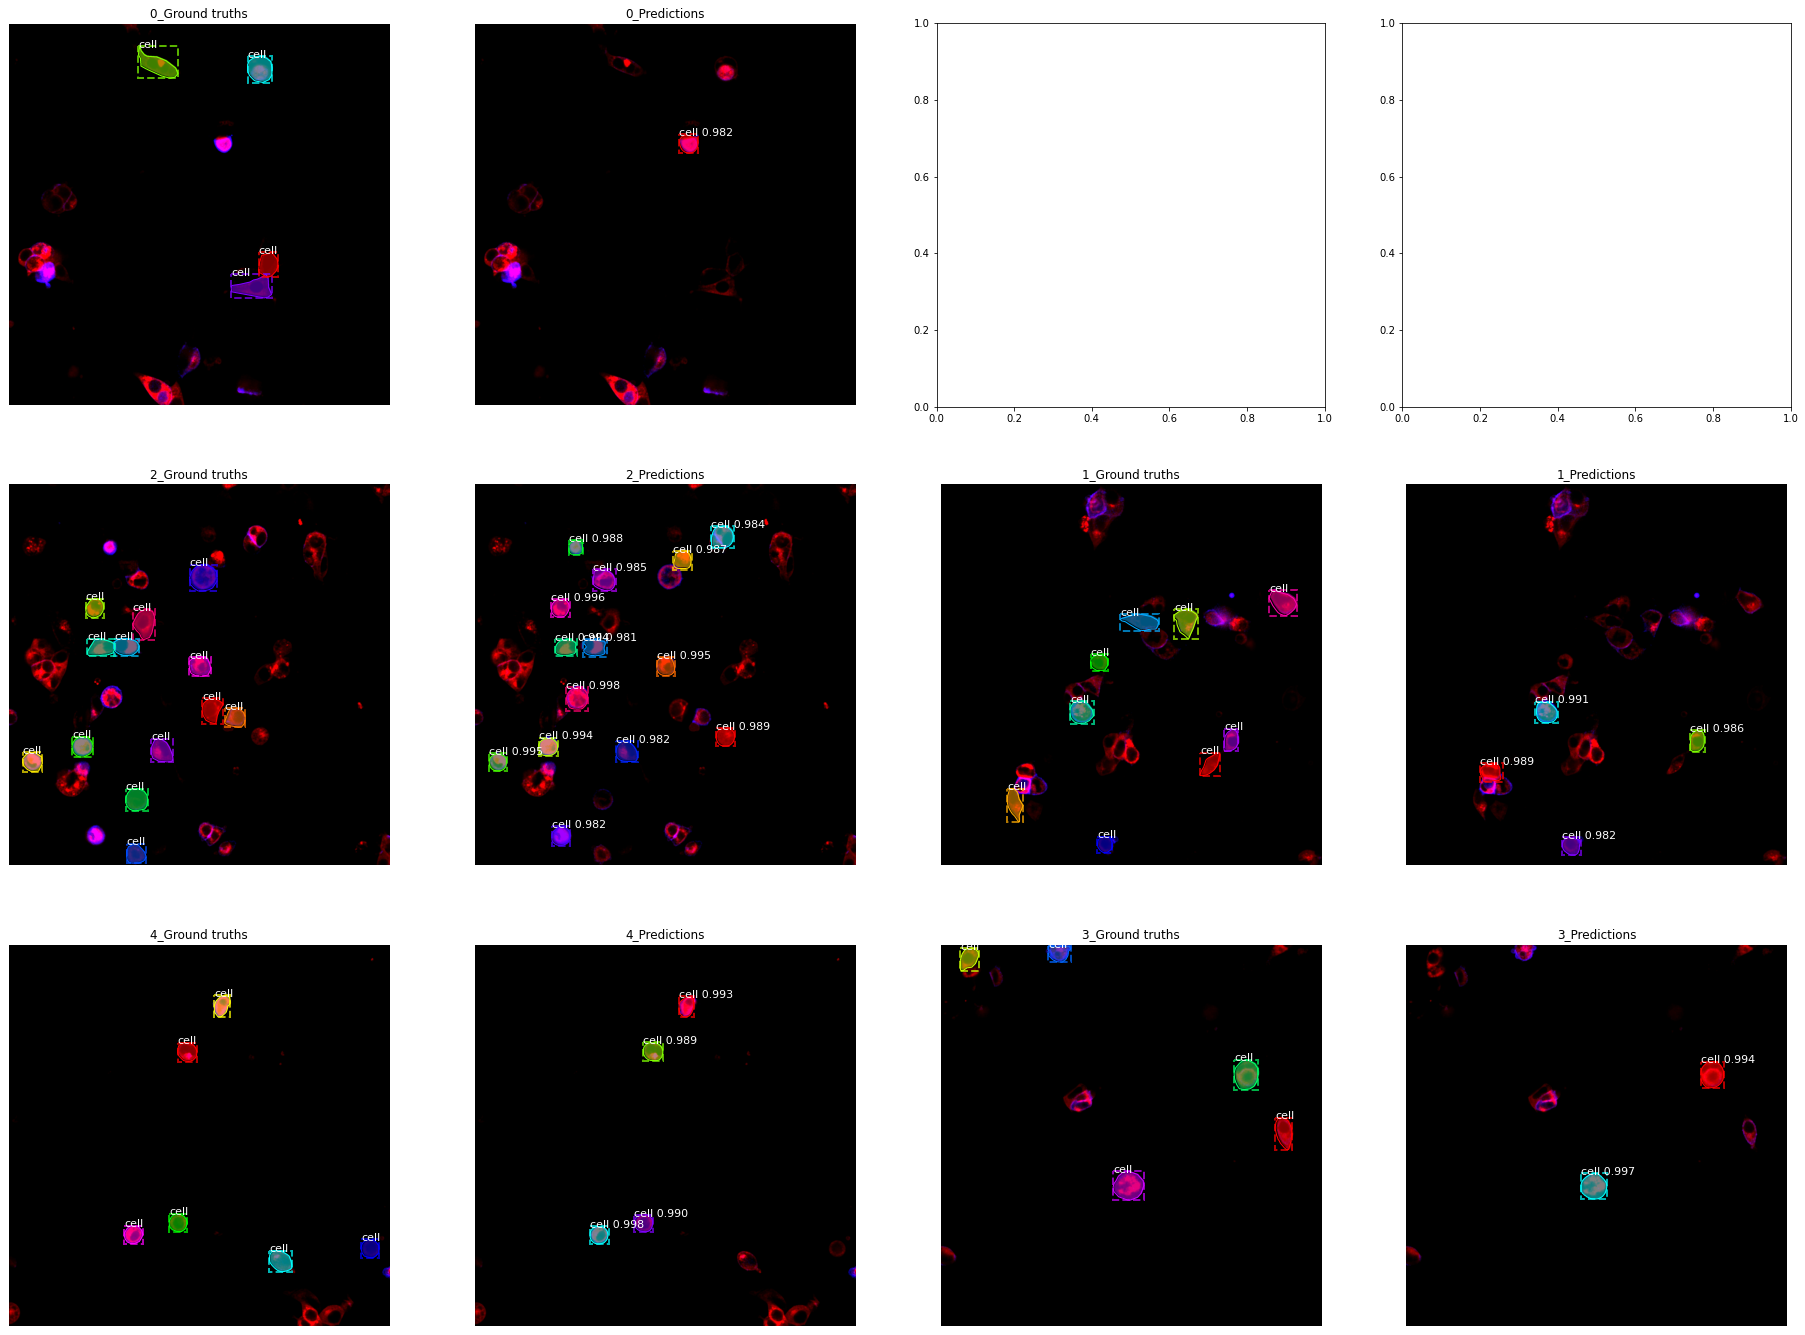

In [11]:
row,col = 0,0
ax = get_ax(rows=3, cols=4, size=8)
if len(dataset.image_ids) < 6:
    limit = len(dataset.image_ids)
else:
    limit = 6
image_ids = random.choice(dataset.image_ids, limit, replace=False)
for i in range(limit):
    image_id = image_ids[i]
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    if gt_class_id.size > 0:
        
    
        info = dataset.image_info[image_id]
#         print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                                dataset.image_reference(image_id)))

        # Run object detection
        results = model.detect([image], verbose=1)

        # Display results
        
        visualize.display_instances(cell2rgb(image), gt_bbox, gt_mask, gt_class_id, 
                                    dataset.class_names, ax=ax[row,col],
                                    title=str(image_id)+"_Ground truths")
        col += 1
        # Display ground truth
        r = results[0]
        visualize.display_instances(cell2rgb(image), r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], ax=ax[row,col],
                                    title=str(image_id)+"_Predictions")
        col += 1
        if i % 2 == 0:
            row += 1
            col = 0
#         log("gt_class_id", gt_class_id)
#         log("gt_bbox", gt_bbox)
#         log("gt_mask", gt_mask)

image ID: cell.B02s11 (0) /home/miska/repos/cell_mrcnn/data/annotated_datasets/2020_11_22_02_55_03/val/B02s11/B02s11.png
Processing 1 images
image                    shape: (2048, 2048, 2)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 2)    min:   -4.50000  max:  253.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  int64
anchors                  shape: (1, 1047552, 4)       min:   -0.17686  max:    1.14560  float32
gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:  115.00000  max: 1471.00000  int32
gt_mask                  shape: (2048, 2048, 4)       min:    0.00000  max:    1.00000  bool


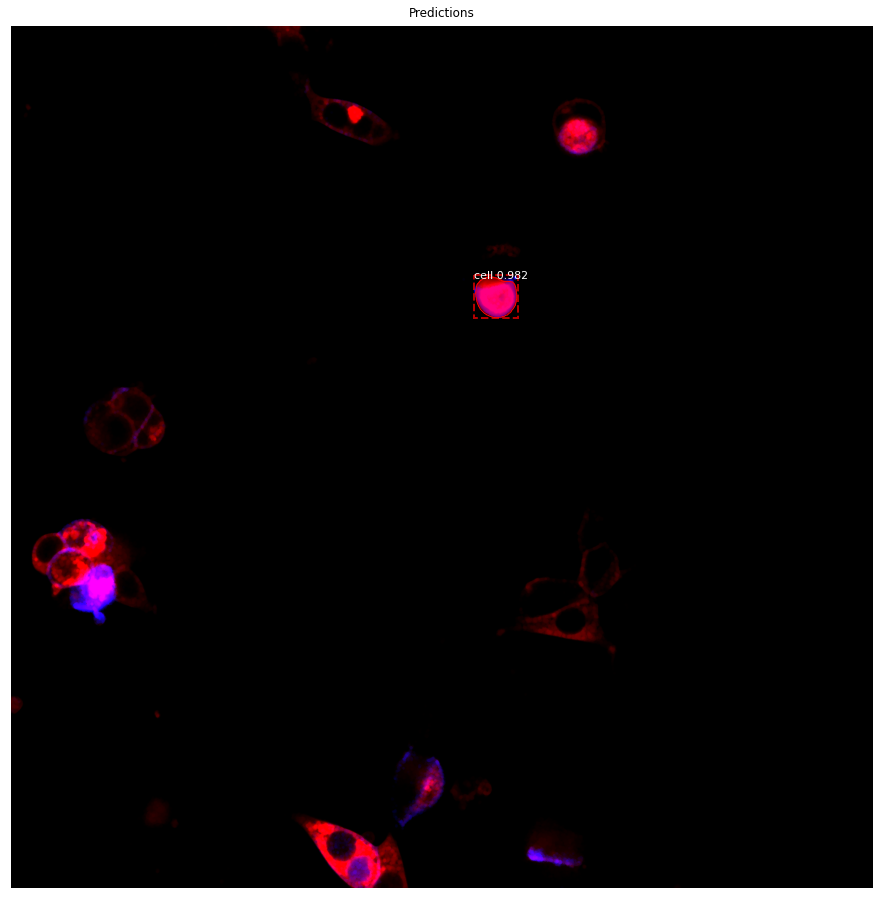

In [12]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(cell2rgb(image), r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: cell.A01s2 (3) /home/miska/repos/cell_mrcnn/data/annotated_datasets/2020_11_22_02_55_03/val/A01s2/A01s2.png
Processing 1 images
image                    shape: (2048, 2048, 2)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 2)    min:   -4.50000  max:  253.50000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  int64
anchors                  shape: (1, 1047552, 4)       min:   -0.17686  max:    1.14560  float32


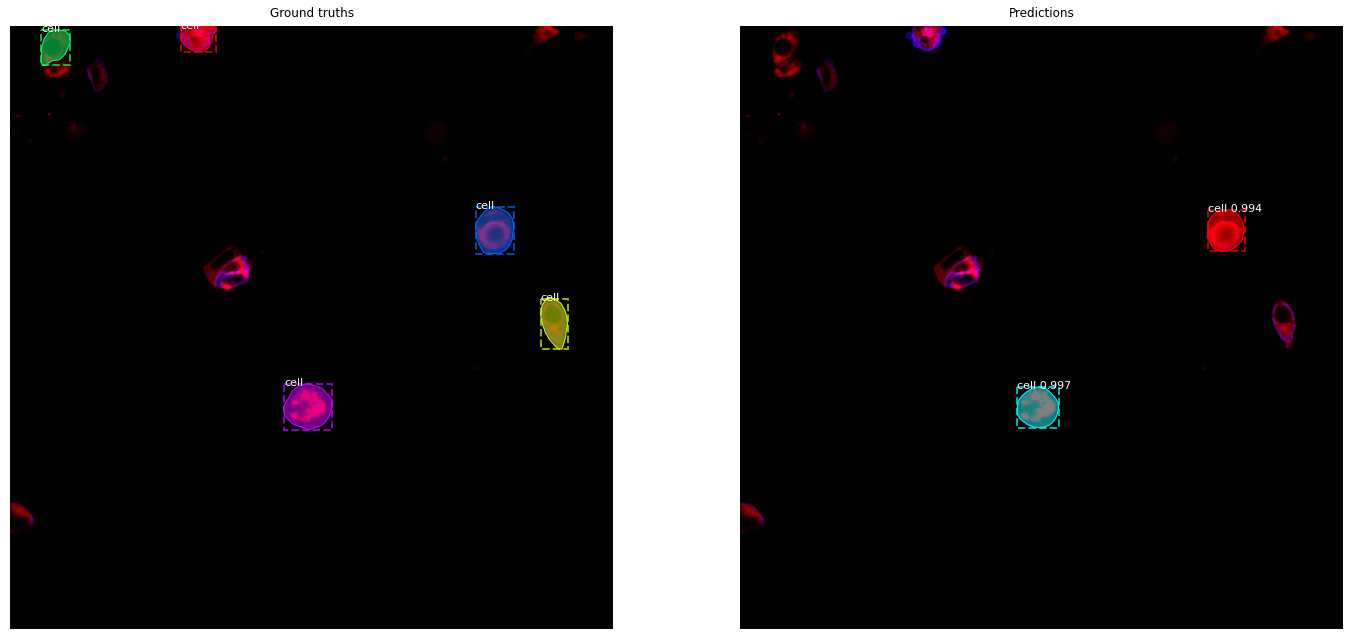

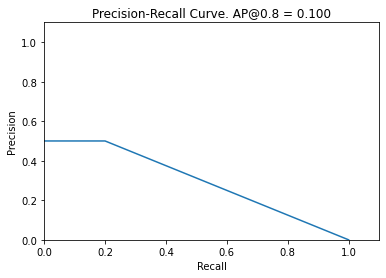

In [21]:
iou=0.8
image_id = 3 #random.choice(dataset.image_ids)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
#if gt_class_id.size > 0:


info = dataset.image_info[image_id]
#         print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                                dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)
r = results[0]
# Display results
ax = get_ax(rows=1, cols=2, size=12)
visualize.display_instances(cell2rgb(image), gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax[0],
                            title="Ground truths")
# Display ground truth
visualize.display_instances(cell2rgb(image), r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax[1],
                            title="Predictions")
# calculate precision-recall
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                      r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=iou)
# Draw precision-recall curve
visualize.plot_precision_recall(AP, precisions, recalls,IoU=iou)

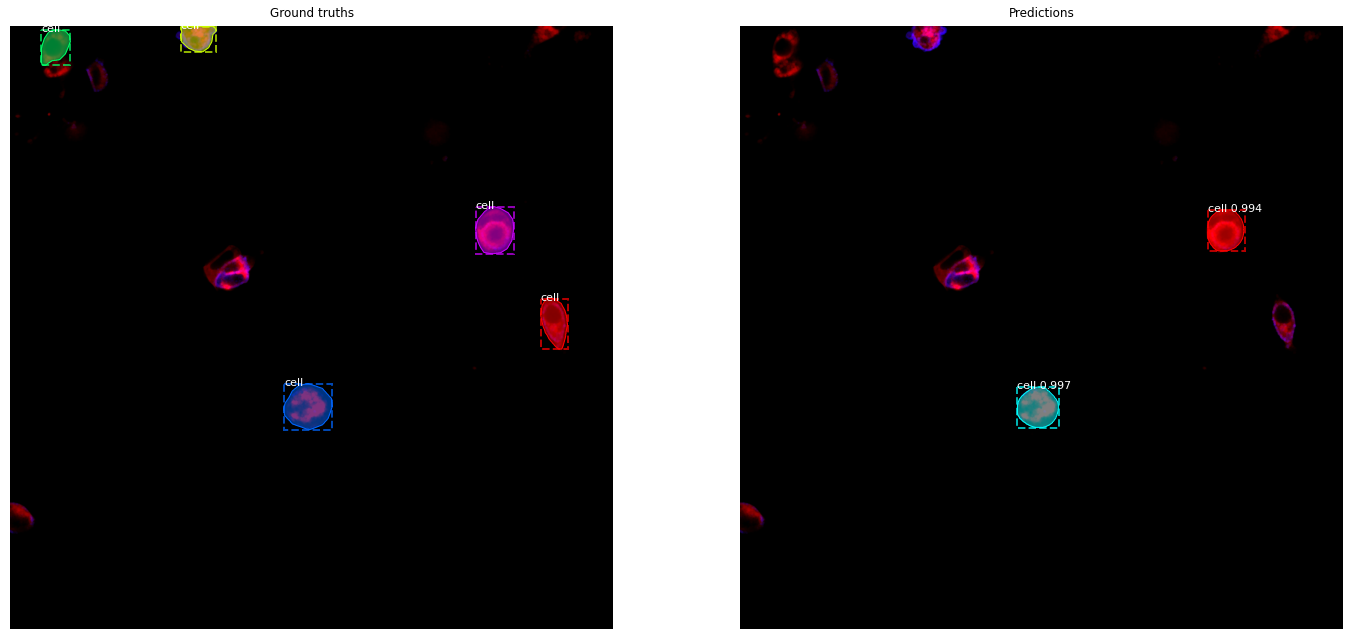

In [26]:
# Display results
ax = get_ax(rows=1, cols=2, size=12)
visualize.display_instances(cell2rgb(image), gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax[0],
                            title="Ground truths")
col += 1
# Display ground truth
visualize.display_instances(cell2rgb(image), r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax[1],
                            title="Predictions")

In [28]:
r['scores']

array([0.99701726, 0.99404967], dtype=float32)

In [27]:
overlaps

array([[0.       , 0.7810817, 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.8633575, 0.       ]],
      dtype=float32)

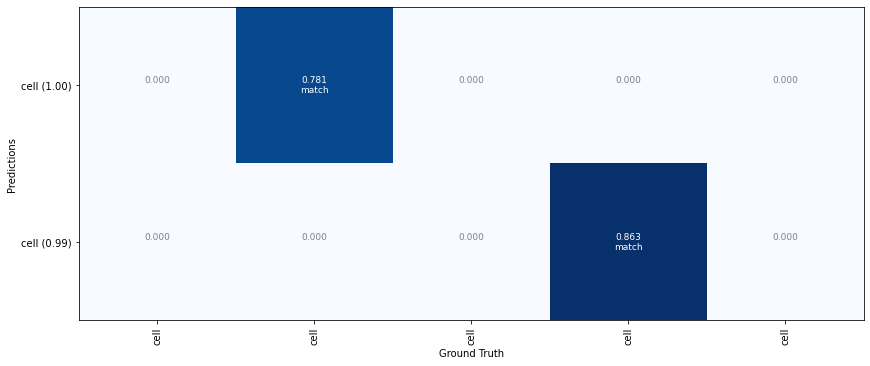

In [19]:
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                  overlaps, dataset.class_names, threshold=0.5)

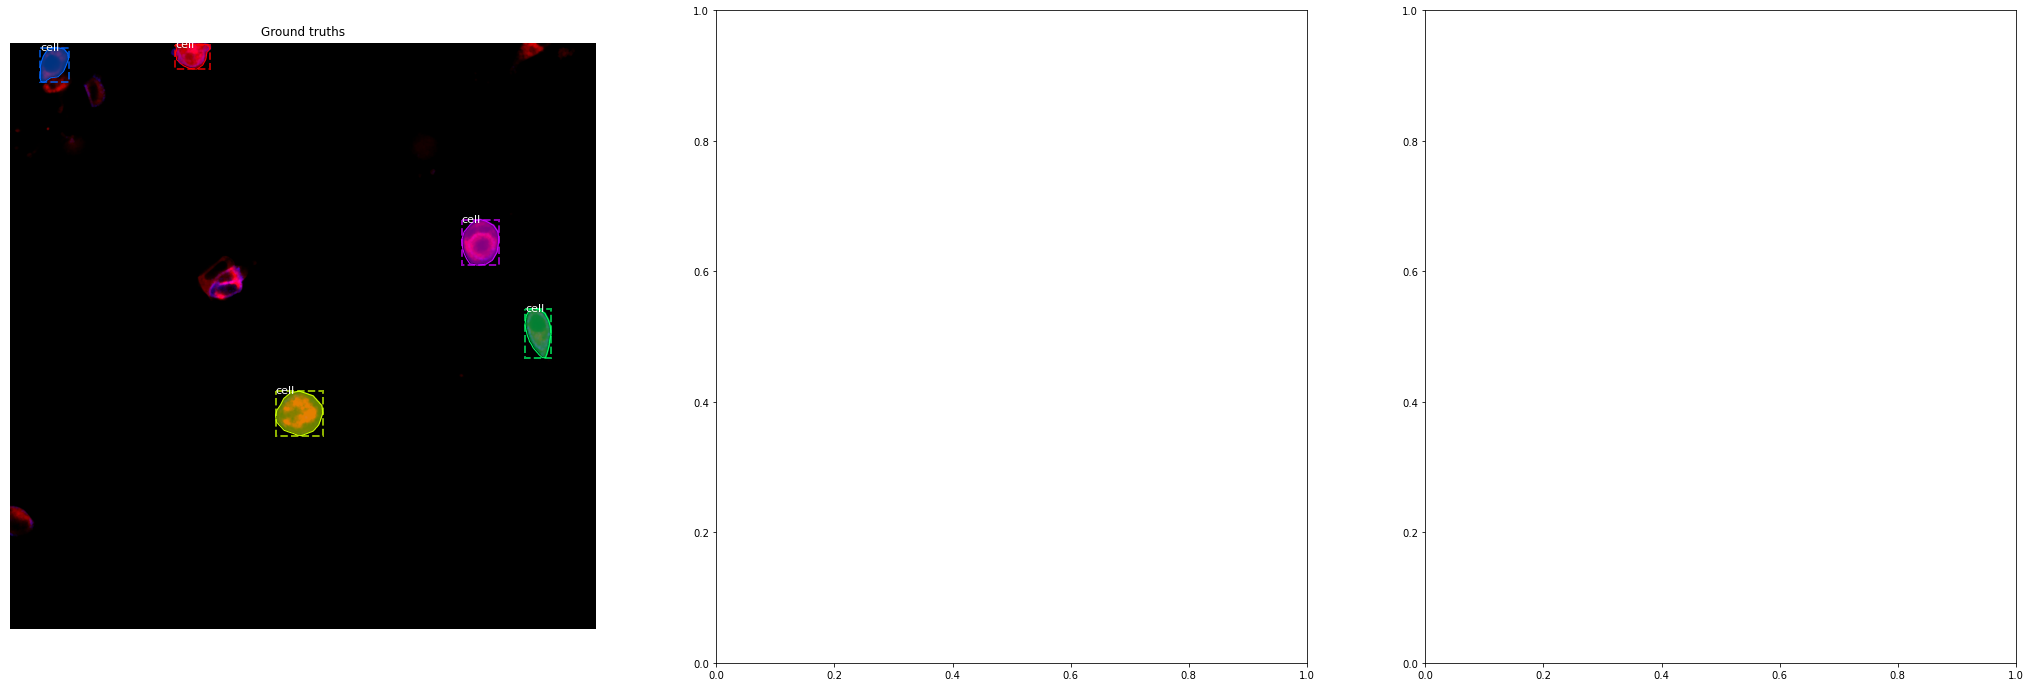

In [15]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, 3, use_mini_mask=False)

# vis images
ax = get_ax(rows=1, cols=3, size=12)
info = dataset.image_info[image_id]
visualize.display_instances(cell2rgb(image), gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax[0],
                            title="Ground truths")
col += 1
# Display ground truth
results = model.detect([image], verbose=0)
r = results[0]

mAP, prec, rec, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.8)

0.5: 0.29562654278495093
0.55: 0.29562654278495093
0.6: 0.29562654278495093
0.65: 0.29562654278495093
0.7: 0.29562654278495093
0.75: 0.22633907404812897
0.8: 0.08185328322861876
0.85: 0.06888031023953642
0.9: 0.03166023056421961
0.95: 0.0010810811072587967


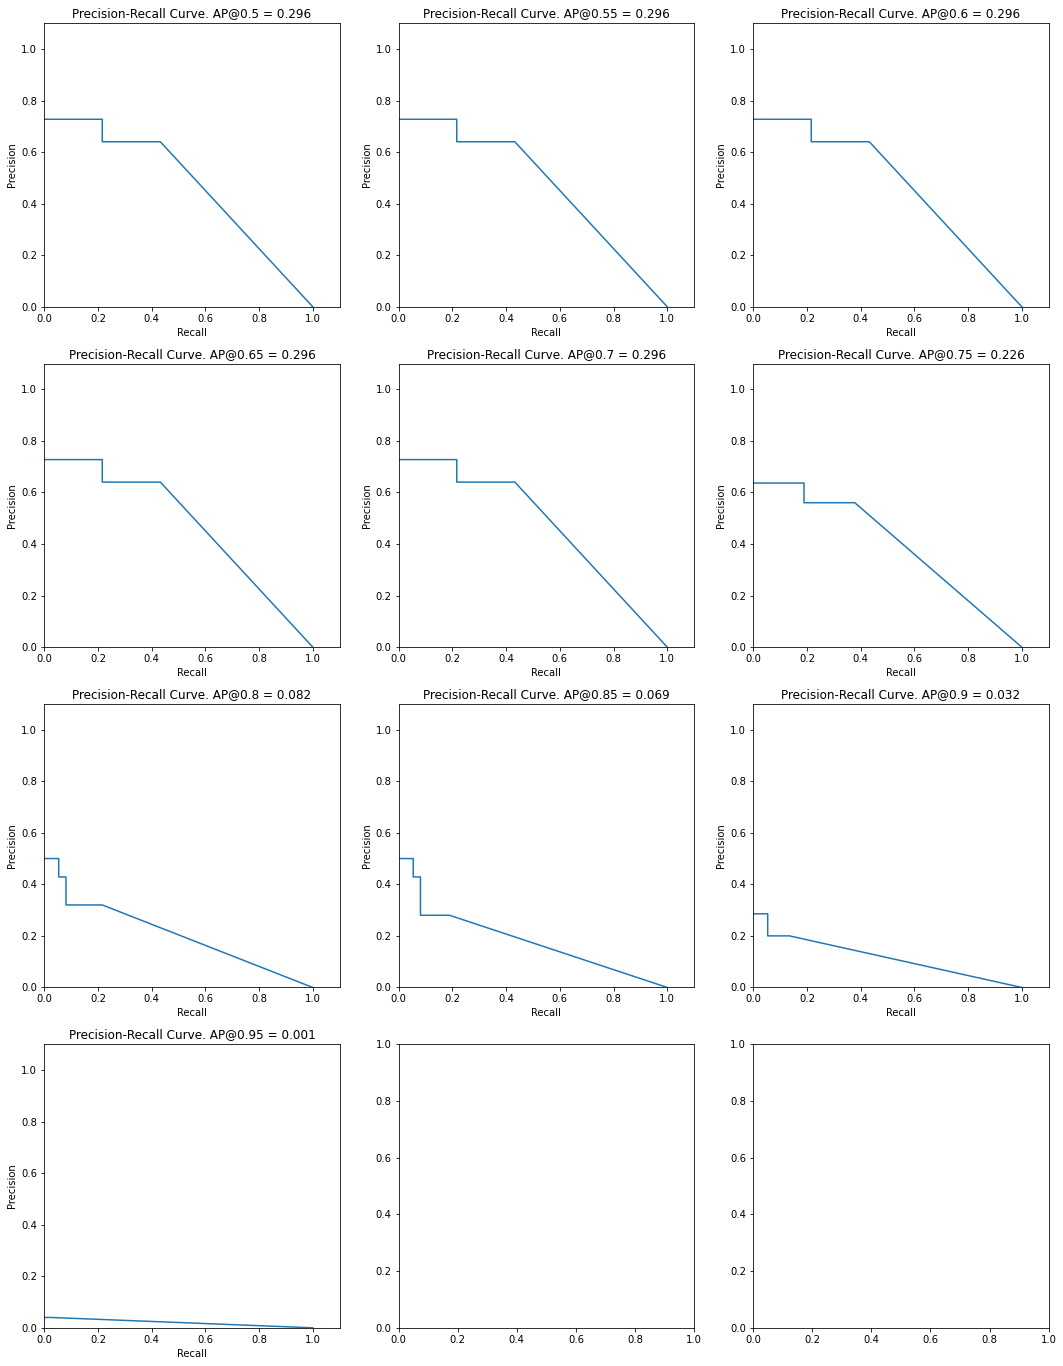

In [16]:
# calculate mAP across multiple images
ax = get_ax(rows=4, cols=3, size=6)
row,col = 0,0
for j, iou in enumerate([0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]):
    print(iou, end=': ')
    for i, image_id in enumerate(dataset.image_ids):
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        results = model.detect([image], verbose=0)
        r = results[0]
        gt_match, pred_match, overlaps = utils.compute_matches(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=iou)

        if i == 0:
            gts = gt_match.copy()
            preds = pred_match.copy()
        else:
            g_temp = gt_match.copy()
            g_temp[g_temp!=-1] = g_temp[g_temp != -1]+(gts.max()+1)
            p_temp = pred_match.copy()
            p_temp[p_temp!=-1] = p_temp[p_temp!=-1]+(preds.max()+1)
            gts = np.concatenate([gts, g_temp])
            preds = np.concatenate([preds, p_temp])

    precisions = np.cumsum(preds > -1) / (np.arange(len(preds)) + 1)
    recalls = np.cumsum(preds > -1).astype(np.float32) / len(gts)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])
    print(mAP)
    # Draw precision-recall curve
    visualize.plot_precision_recall(mAP, precisions, recalls, IoU=iou, ax=ax[row,col])
    col += 1
    if (j+1) % 3 == 0:
        row += 1
        col = 0

In [17]:
precisions

array([0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02272727,
       0.02222222, 0.02173913, 0.        ])

In [18]:
recalls

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02702703, 0.02702703,
       0.02702703, 0.02702703, 1.        ])

In [189]:
preds

array([ 0.,  1., -1., -1., -1.,  2.,  6.,  3.,  4.,  5., -1.,  8.,  7.])

In [177]:
g2

array([4., 5., 6., 3.])

In [178]:
p2

array([ 6.,  3.,  4.,  5., -1.])

In [145]:
pred_match > -1

array([ True, False, False, False])

In [146]:
np.cumsum(pred_match > -1) 

array([1, 1, 1, 1])

In [147]:
(np.arange(len(pred_match))+1)

array([1, 2, 3, 4])

In [148]:
overlaps

array([[0.80553204],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

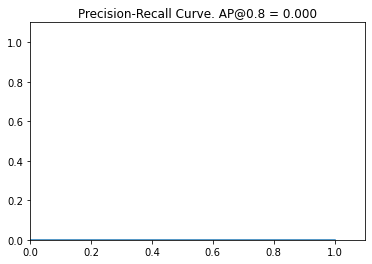

In [129]:
visualize.plot_precision_recall(mAP, prec, rec,IoU=0.8)

In [14]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids, ious=[0.1,0.5,0.55,0.65,0.7,0.75,0.8,0.85,0.9,0.95]):
    AP_dict = {}
    for iou in ious:
        AP_dict[iou] = []
    for i,image_id in enumerate(image_ids):
        print('\r {}/{}'.format(i+1,len(image_ids)),end='')
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        for iou, APs in AP_dict.items():
            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                  r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold=iou)
            APs.append(AP)
    print('')
    return AP_dict

In [15]:
image_ids = dataset.image_ids
AP_dict = compute_batch_ap(image_ids)
for iou in AP_dict:
    APs = np.array(AP_dict[iou])
    AP = np.nan_to_num(APs).mean()
    print('AP@{}IoU is: {}'.format(iou,AP))

 5/5
AP@0.1IoU is: 0.9
AP@0.5IoU is: 0.8
AP@0.55IoU is: 0.8
AP@0.65IoU is: 0.8
AP@0.7IoU is: 0.8
AP@0.75IoU is: 0.8
AP@0.8IoU is: 0.8
AP@0.85IoU is: 0.5125
AP@0.9IoU is: 0.2
AP@0.95IoU is: 0.0


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [17]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (1047552,)            min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (128, 4)              min:   -1.87347  max:    1.75988  float64
positive_anchors         shape: (29, 4)               min:  -13.25483  max: 1960.00000  float64
negative_anchors         shape: (99, 4)               min:  -96.00000  max: 2077.25483  float64
neutral anchors          shape: (1047424, 4)          min: -362.03867  max: 2346.03867  float64
refined_anchors          shape: (29, 4)               min:    3.00000  max: 1964.00000  float32


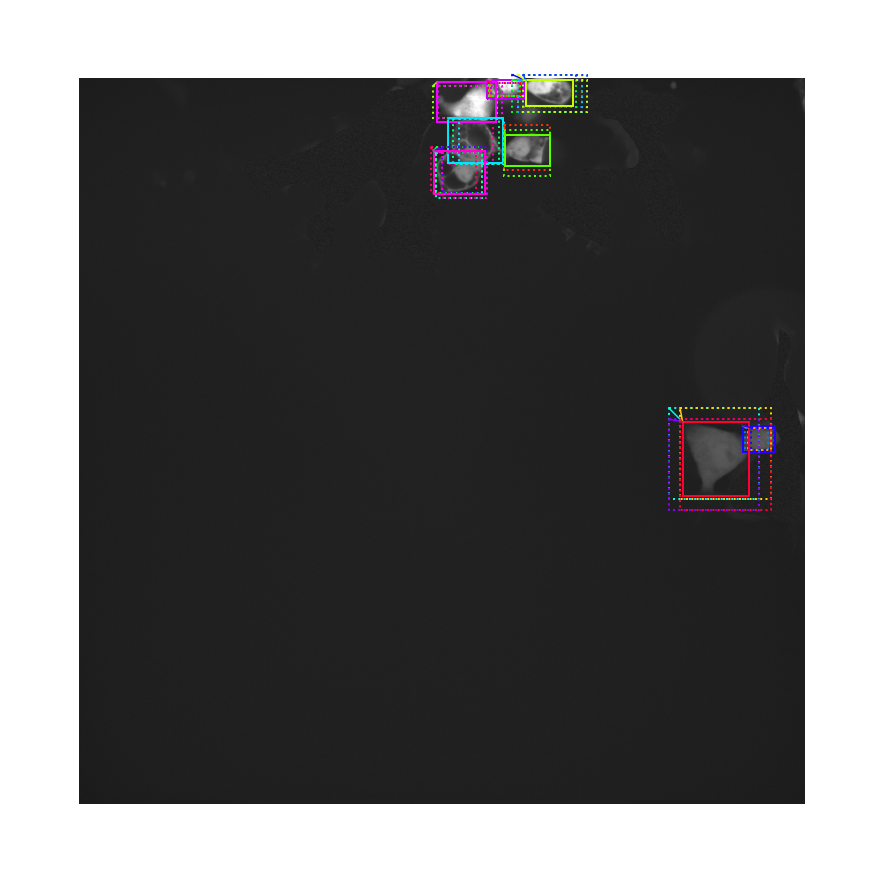

In [18]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(cell2rgb(image), boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [19]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 1047552, 2)       min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.17686  max:    1.14560  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.17589  max:    1.12440  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1024,)               min:    0.00000  max: 1803.00000  int32
proposals                shape: (1, 1024, 4)          min:    0.00000  max:    1.00000  float32


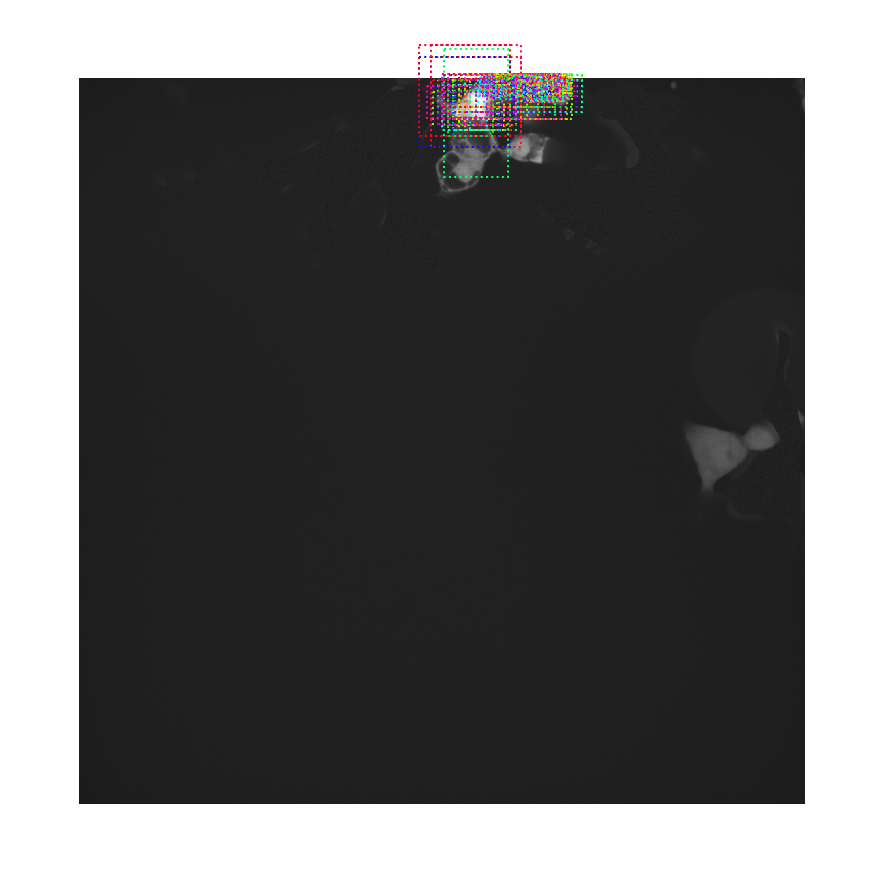

In [22]:
# Show top anchors by score (before refinement)
limit = 300
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(cell2rgb(image), boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

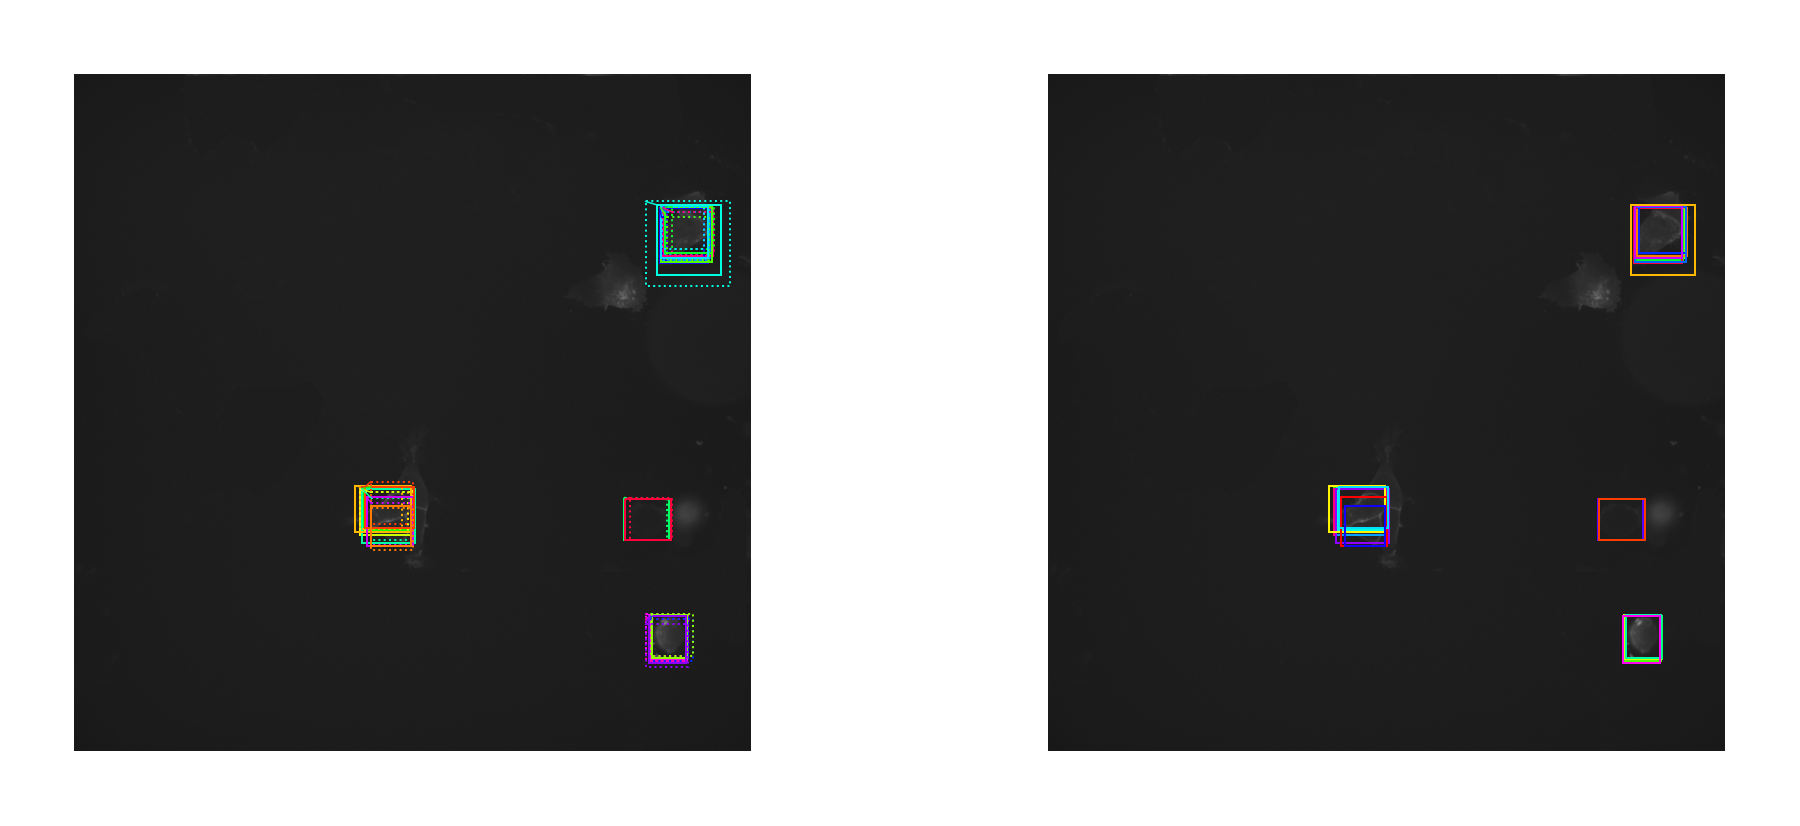

In [32]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 25
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(cell2rgb(image), boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(cell2rgb(image), refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 15
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(cell2rgb(image), refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

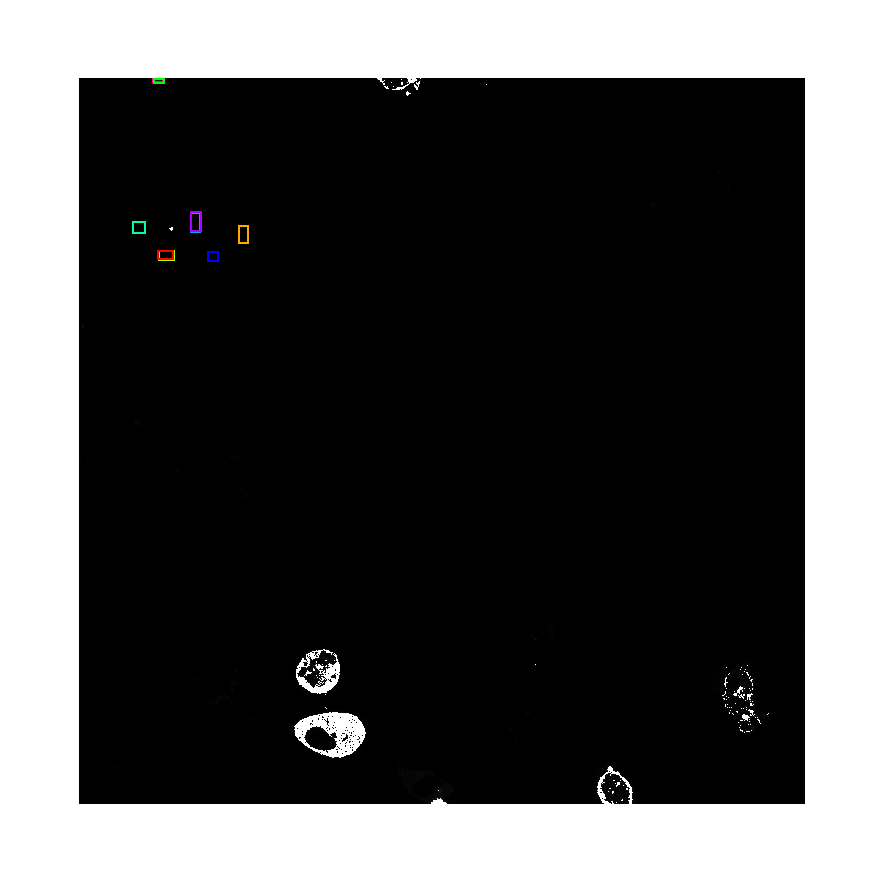

In [26]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 9
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(cell2rgb(image), refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [27]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1024, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1024, 2)          min:    0.00007  max:    0.99993  float32
deltas                   shape: (1, 1024, 2, 4)       min:   -3.28602  max:    3.43042  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00004  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


8 detections: ['cell' 'cell' 'cell' 'cell' 'cell' 'cell' 'cell' 'cell']


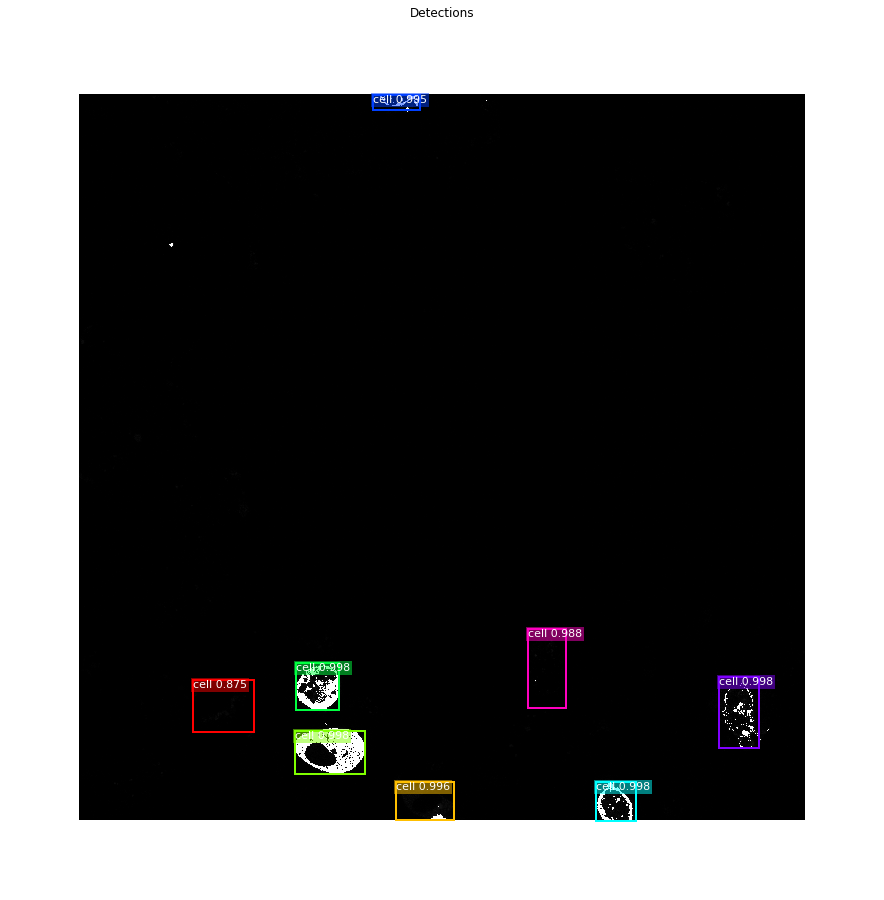

In [28]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    cell2rgb(image), 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [29]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1024 Valid proposals out of 1024
240 Positive ROIs
[('BG', 784), ('cell', 240)]


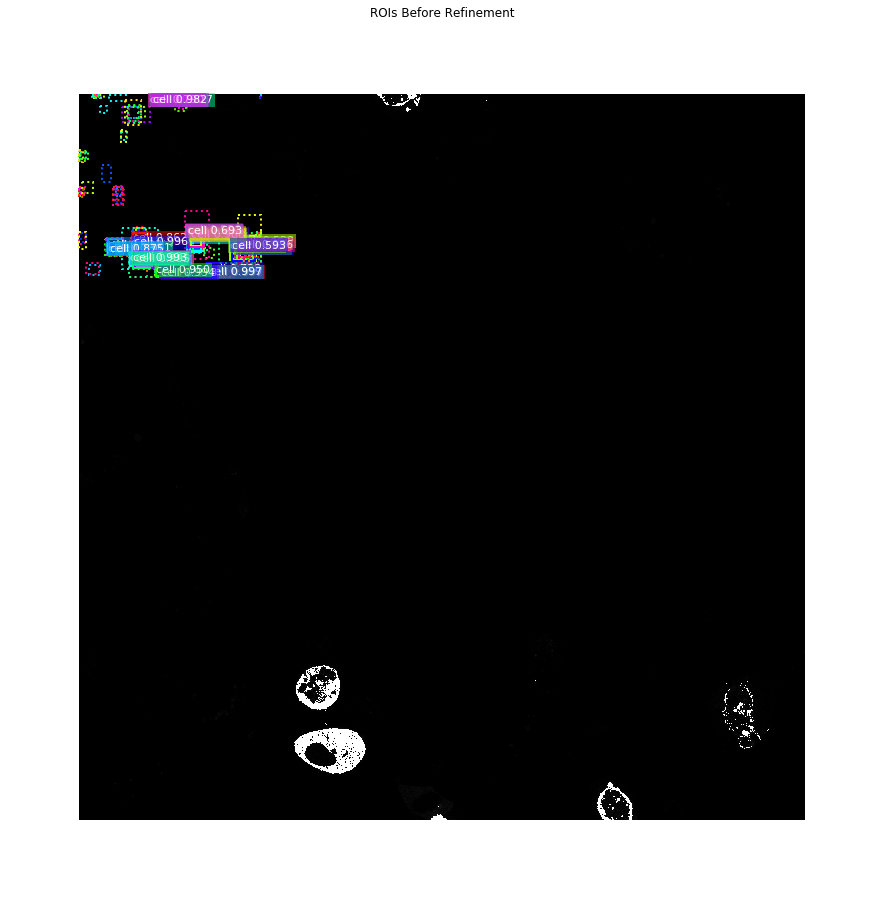

In [30]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(cell2rgb(image), boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1024, 4)             min:   -3.15433  max:    3.43042  float32
refined_proposals        shape: (1024, 4)             min:   -1.00000  max:  532.00000  int32


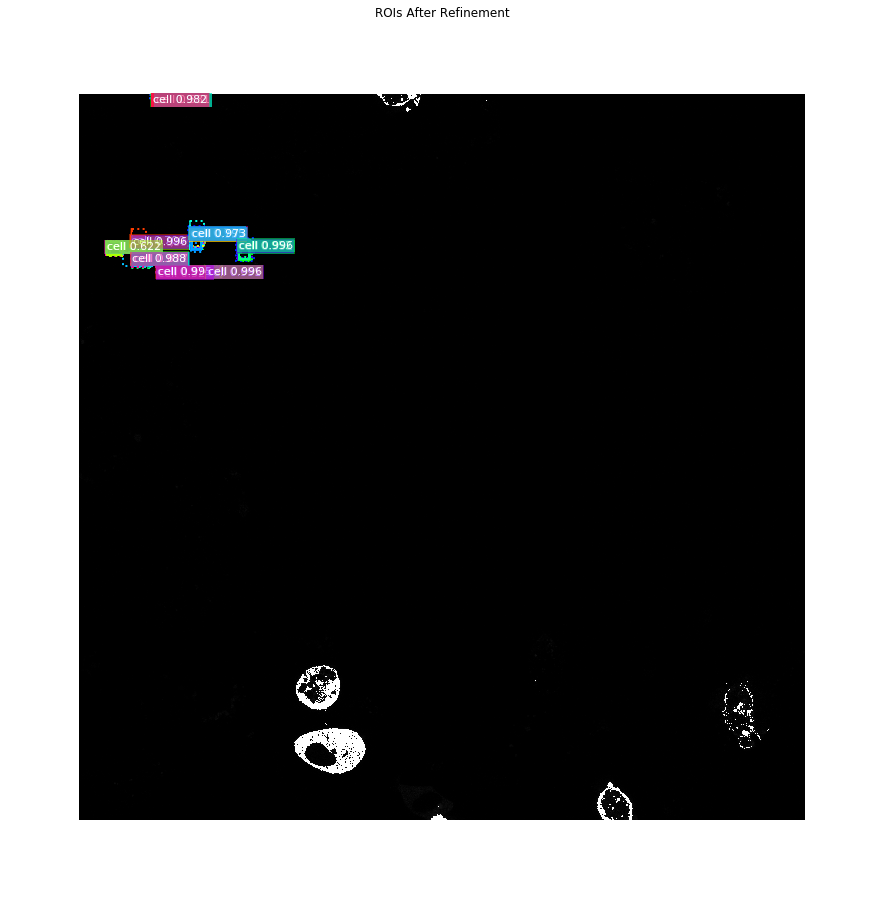

In [31]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 50
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(cell2rgb(image), boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [32]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 240 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  24  28  30  31  33  34  35  36  37  38  39  41  42
  43  44  45  46  47  49  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  70  72  73  77  80  82  84  85  87  89  90  92  94
  96  98  99 101 103 104 106 107 112 113 114 116 117 119 120 121 127 130
 133 136 139 145 150 151 154 155 156 157 160 161 163 165 166 167 168 170
 171 173 176 178 179 181 182 186 188 190 196 199 200 201 204 206 210 211
 213 217 220 225 227 229 234 244 247 250 251 253 255 261 272 276 277 280
 281 283 296 297 300 322 327 334 338 349 353 358 361 368 372 374 375 377
 395 398 401 407 414 415 418 435 440 455 456 459 475 477 485 492 501 502
 508 509 514 518 521 525 528 529 538 539 544 547 552 554 556 563 566 571
 581 591 594 608 614 615 633 640 648 656 665 671 672 673 680 689 700 711
 725 726 732 747 765 782 792 801 805 816 833 889 894 901 904 907 908 912
 930 935 945 949 960 979]


In [33]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.8 confidence. Keep 155:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  24  28  30  31  33  34  35  36  37  38  39  41  42
  43  44  45  46  47  49  51  52  54  55  56  57  58  59  61  63  65  66
  67  72  73  77  80  82  84  85  89  90  92  94  96  99 101 103 104 112
 113 116 117 120 127 136 150 151 154 155 156 157 161 163 166 167 170 173
 176 181 190 196 199 200 201 204 210 211 213 217 229 234 244 250 255 276
 277 280 283 296 300 322 327 338 349 358 368 375 377 395 398 415 418 435
 459 477 485 501 509 518 521 539 552 566 591 614 633 648 656 671 672 673
 680 700 711 725 732 765 782 801 833 904 935]


#### Per-Class Non-Max Suppression

In [34]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

cell                  : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  24  28  30  31  33  34  35  36  37  38  39  41  42
  43  44  45  46  47  49  51  52  54  55  56  57  58  59  61  63  65  66
  67  72  73  77  80  82  84  85  89  90  92  94  96  99 101 103 104 112
 113 116 117 120 127 136 150 151 154 155 156 157 161 163 166 167 170 173
 176 181 190 196 199 200 201 204 210 211 213 217 229 234 244 250 255 276
 277 280 283 296 300 322 327 338 349 358 368 375 377 395 398 415 418 435
 459 477 485 501 509 518 521 539 552 566 591 614 633 648 656 671 672 673
 680 700 711 725 732 765 782 801 833 904 935] -> [ 17  58  13   6   4 418  49  80]

Kept after per-class NMS: 8
[  4   6  13  17  49  58  80 418]


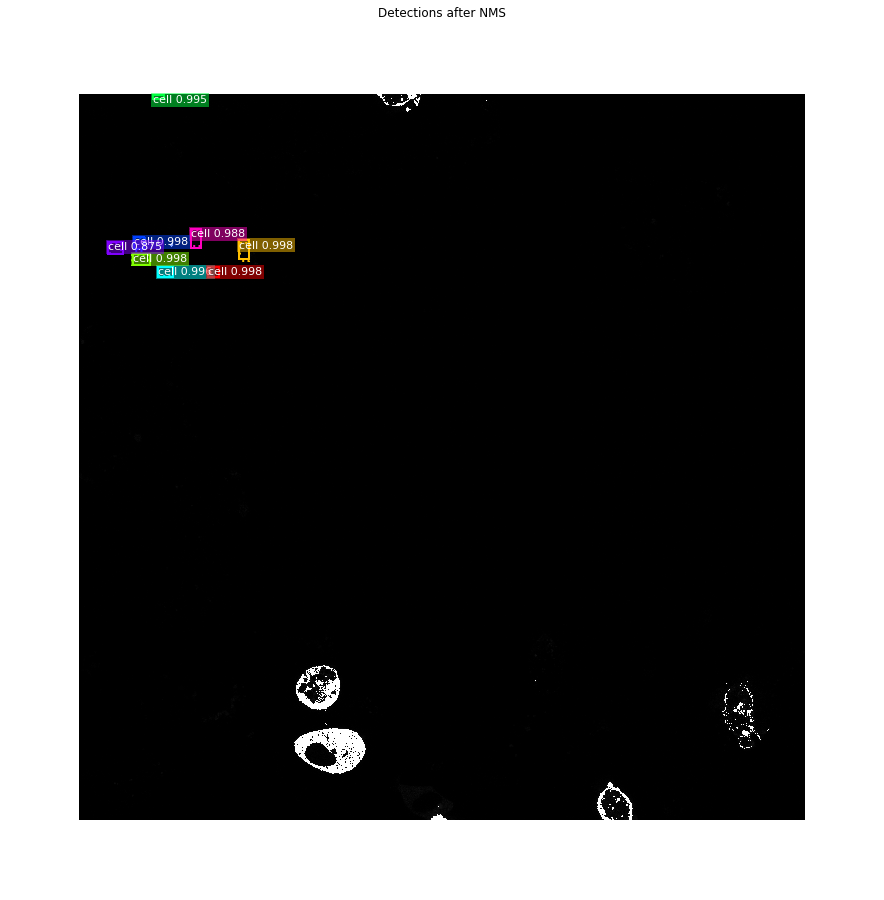

In [35]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    cell2rgb(image), boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

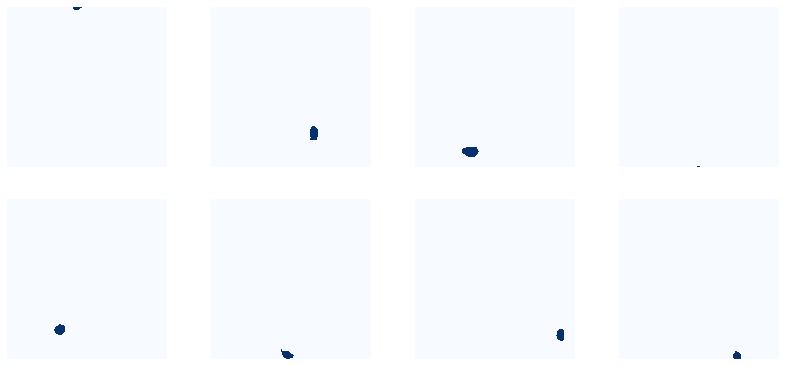

In [36]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [37]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00004  max:    1.00000  float32
8 detections: ['cell' 'cell' 'cell' 'cell' 'cell' 'cell' 'cell' 'cell']


In [38]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (8, 28, 28)           min:    0.00004  max:    1.00000  float32
det_masks                shape: (8, 2048, 2048)       min:    0.00000  max:    1.00000  bool


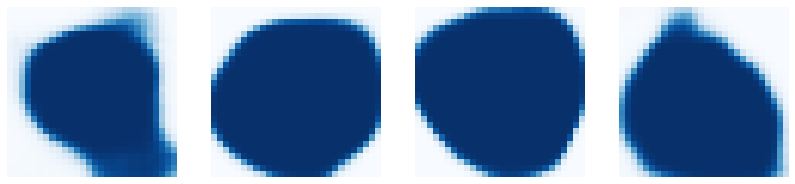

In [39]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

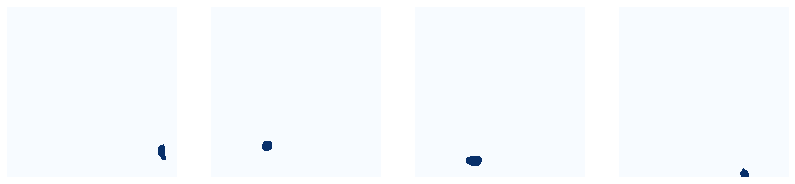

In [40]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [41]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
#    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 2048, 2048, 1)    min:   -0.50000  max:  254.50000  float32
res2c_out                shape: (1, 512, 512, 256)    min:    0.00000  max:   77.75297  float32
res3c_out                shape: (1, 256, 256, 512)    min:    0.00000  max:   49.59814  float32
rpn_bbox                 shape: (1, 1047552, 4)       min:   -8.77107  max:   70.87766  float32
roi                      shape: (1, 1024, 4)          min:    0.00000  max:    1.00000  float32


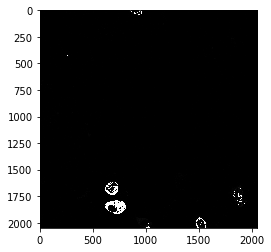

In [42]:
# Input image (normalized)
_ = plt.imshow(cell2rgb(modellib.unmold_image(activations["input_image"][0],config)))

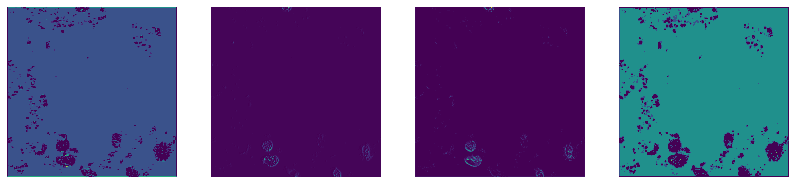

In [43]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)